In [270]:
import os, cv2
import numpy as np
import pandas as pd
import random

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import torch.serialization as tserial
import albumentations as album

from PIL import Image
from tqdm import tqdm
from lgbt import lgbt
from tifffile import imread, imwrite
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from pathlib import Path
from segmentation_models_pytorch.decoders.unet.model import Unet
from segmentation_models_pytorch import utils as smp_utils

In [271]:
TRAINING = True
EPOCHS = 50
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

In [272]:
DATA_DIR = './massachusetts-roads-dataset/tiff/'
OUTPUT_DIR = './massachusetts-roads-dataset-processed/'
WHITE_THRESHOLD = 250

In [273]:
# def process_dataset(images_dir, masks_dir, output_images_dir, output_masks_dir):
#     os.makedirs(output_images_dir, exist_ok=True)
#     os.makedirs(output_masks_dir, exist_ok=True)
    
#     image_files = [f for f in os.listdir(images_dir) if f.lower().endswith('.tiff')]
    
#     for img_name in tqdm(image_files, desc="Processing images"):
#         img_path = os.path.join(images_dir, img_name)
        
#         mask_name = os.path.splitext(img_name)[0] + '.tif'
#         mask_path = os.path.join(masks_dir, mask_name)
        
#         if not os.path.exists(mask_path):
#             tqdm.write(f"Mask not found for {img_name} (expected: {mask_name}), skipping...")
#             continue
            
#         try:
#             img = imread(img_path)
#             mask = imread(mask_path)
            
#             if img is None:
#                 tqdm.write(f"Failed to read image: {img_name}")
#                 continue
#             if mask is None:
#                 tqdm.write(f"Failed to read mask: {mask_name}")
#                 continue
                
#             if len(img.shape) == 3 and img.shape[2] == 4:
#                 img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
            
#             gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
#             _, thresh = cv2.threshold(gray, WHITE_THRESHOLD, 255, cv2.THRESH_BINARY)
#             contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
#             if not contours:
#                 x, y, w, h = 0, 0, img.shape[1], img.shape[0]
#             else:
#                 x, y, w, h = cv2.boundingRect(np.vstack(contours))
            
#             cropped_img = img[y:y+h, x:x+w]
#             cropped_mask = mask[y:y+h, x:x+w]
            
#             imwrite(os.path.join(output_images_dir, img_name), cropped_img)
#             imwrite(os.path.join(output_masks_dir, mask_name), cropped_mask)
            
#         except Exception as e:
#             tqdm.write(f"Error processing {img_name}: {str(e)}")

In [274]:
# train_images = os.path.join(DATA_DIR, 'train')
# train_labels = os.path.join(DATA_DIR, 'train_labels')
# output_train = os.path.join(OUTPUT_DIR, 'train')
# output_labels = os.path.join(OUTPUT_DIR, 'train_labels')

# print("Starting processing...")
# process_dataset(train_images, train_labels, output_train, output_labels)
# print("\nProcessing completed!")

In [275]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [276]:
class_dict = pd.read_csv("./massachusetts-roads-dataset/label_class_dict.csv")
select_classes = class_dict['name'].tolist()
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('Class Names: ', select_classes)
print('Class RGB values: ', class_rgb_values)

Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [277]:
select_class_indices = [select_classes.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

In [278]:
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

In [279]:
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map
    
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

In [280]:
class RoadsDataset(torch.utils.data.Dataset):
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir)) if not image_id.startswith('.')]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir)) if not image_id.startswith('.')]
            
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.image_paths)

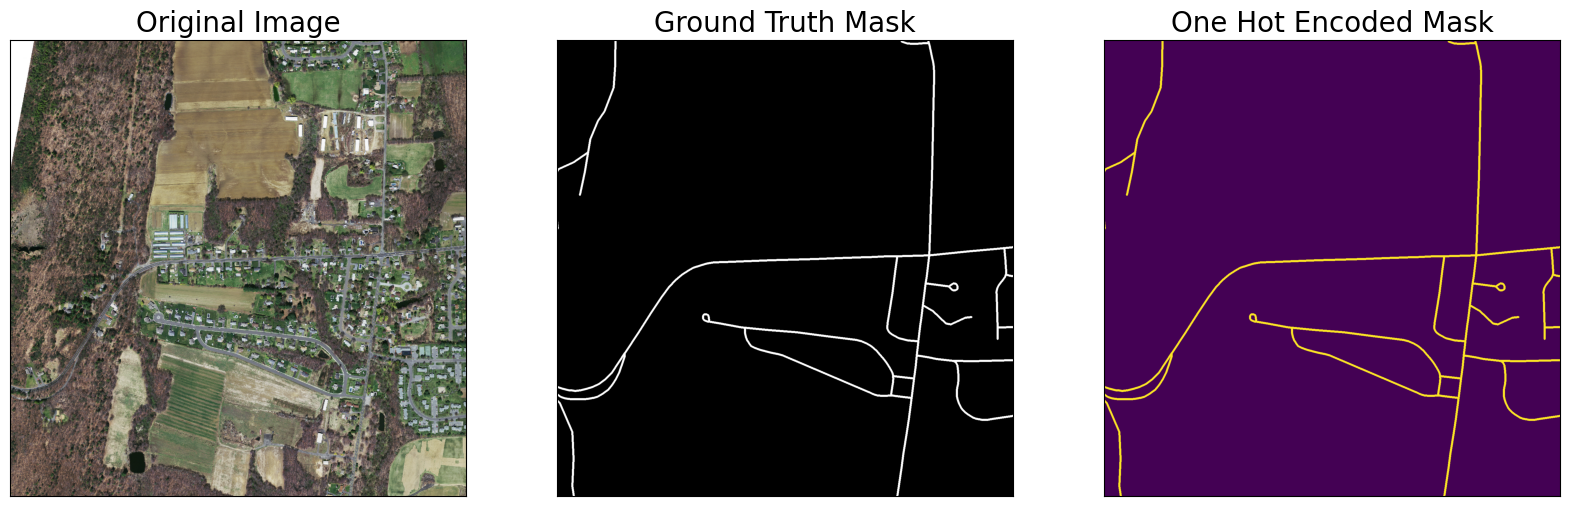

In [281]:
dataset = RoadsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [282]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf([
            album.HorizontalFlip(p=0.5),
            album.VerticalFlip(p=0.5),
            album.RandomRotate90(p=0.5),
        ], p=0.75),
        album.RandomBrightnessContrast(p=0.2),
        album.GaussianBlur(p=0.1)
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None): 
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

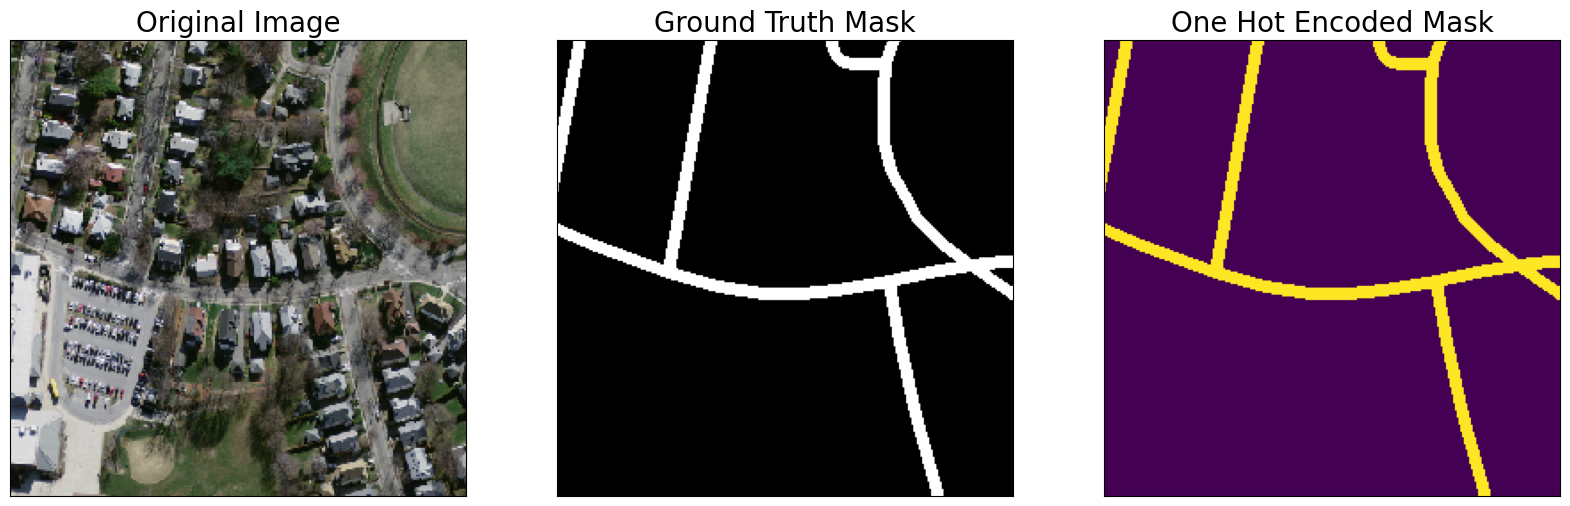

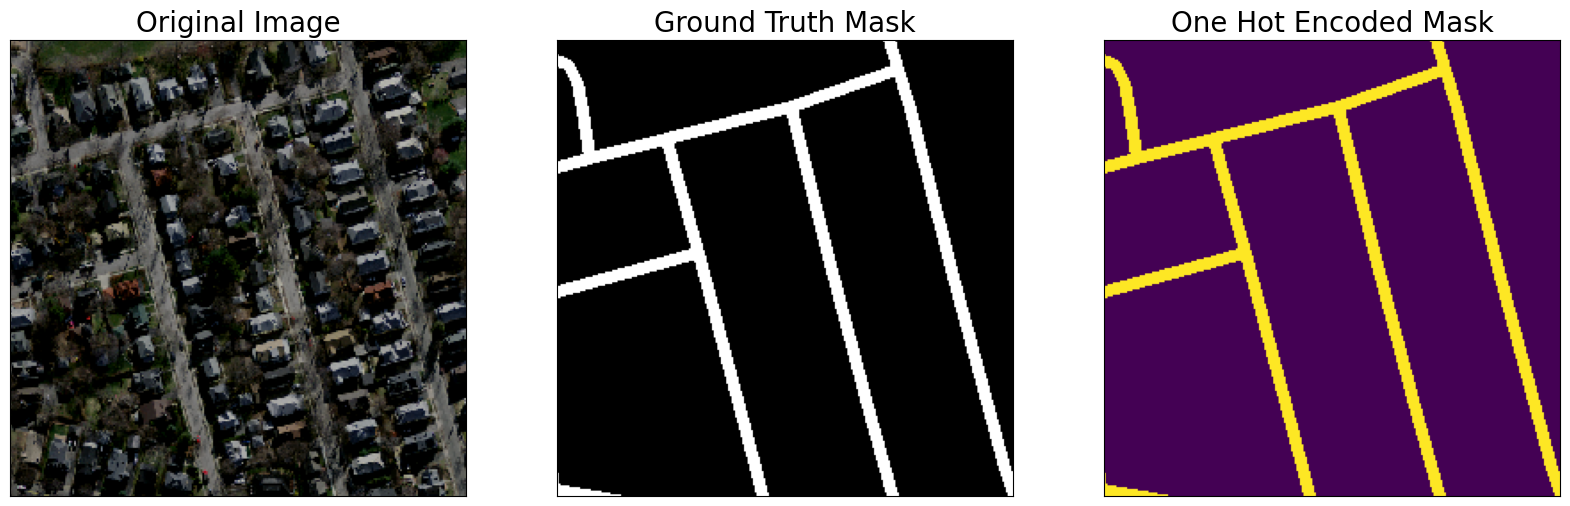

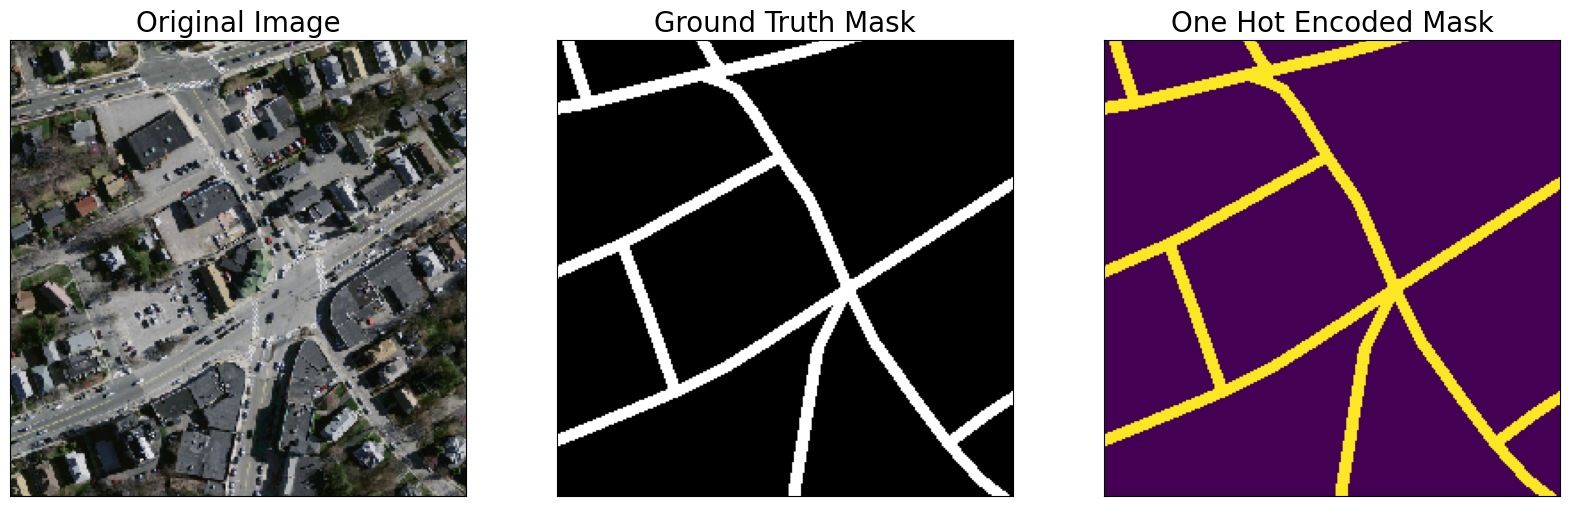

In [283]:
augmented_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [284]:
model = Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(select_classes), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [285]:
train_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [286]:
class SoftBCEWithLogitsLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce_loss = smp.losses.SoftBCEWithLogitsLoss()
        self.__name__ = 'soft_bce_with_logits'

    def forward(self, y_pred, y_true):
        return self.bce_loss(y_pred, y_true)

In [287]:
loss = SoftBCEWithLogitsLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5)
]

optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.00008)])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)

In [288]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [289]:
if TRAINING:
    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in lgbt(range(0, EPOCHS)):
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
train:   0%|                                                                                                                                                | 0/70 [00:00<?, ?it/s]

valid: 100%|███████████████████████████████| 14/14 [00:01<00:00,  8.82it/s, soft_bce_with_logits - 0.6594, iou_score - 0.8012, fscore - 0.888, precision - 0.8976, recall - 0.8791]
Model saved!
🌈            :002% ▋                                                       [1/50] [27.65s, 0.04it/s]  
Epoch: 1
valid: 100%|██████████████████████████████| 14/14 [00:01<00:00,  8.85it/s, soft_bce_with_logits - 0.6264, iou_score - 0.8405, fscore - 0.9124, precision - 0.9116, recall - 0.9133]
Model saved!
🌈            :004% ▋▋                                                      [2/50] [55.27s, 0.04it/s]  
Epoch: 2
valid: 100%|██████████████████████████████| 14/14 [00:01<00:00,  8.83it/s, soft_bce_with_logits - 0.6094, iou_score - 0.8517, fscore - 0.9191, precision - 0.9127, recall - 0.9257]
Model saved!
🌈            :006% ▋▋▋                                                     [3/50] [82.74s, 0.04it/s]  
Epoch: 3
valid: 100%|██████████████████████████████| 14/14 [00:01<00:00,  8.85it/s, soft_bce_w

In [290]:
best_model = torch.load('./best_model.pth', map_location=DEVICE, weights_only=False)

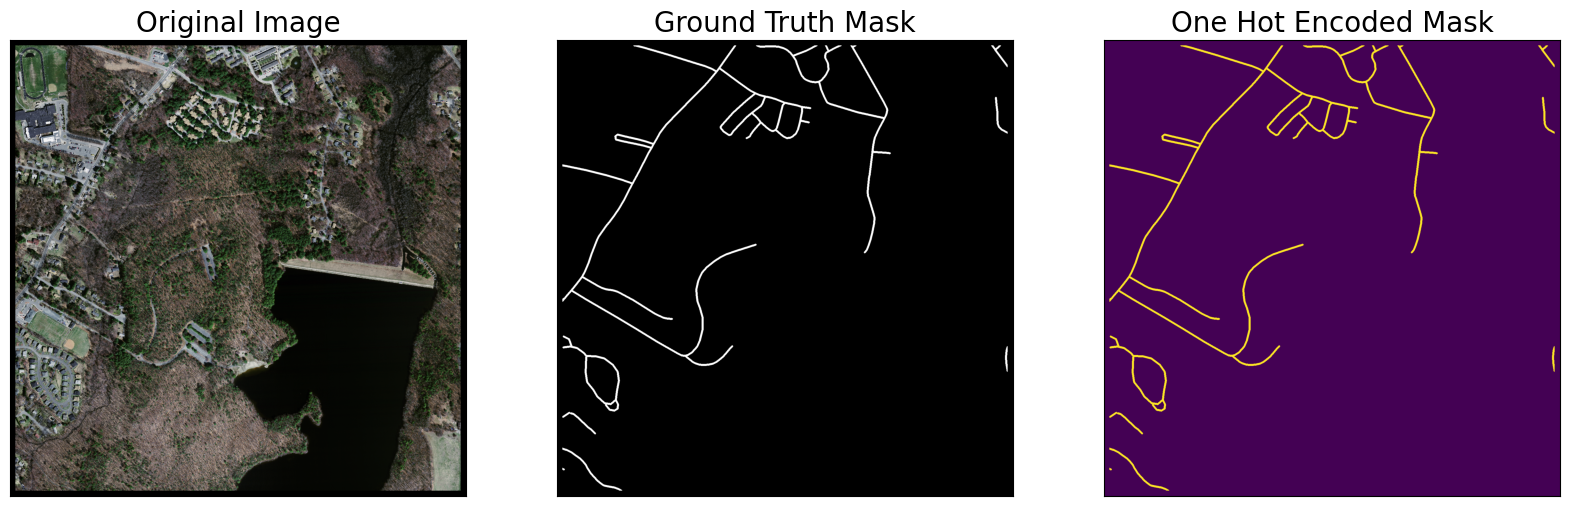

In [291]:
test_dataset = RoadsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

test_dataset_vis = RoadsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [292]:
def crop_image(image, target_image_dims=[1500,1500,3]):
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2
    if padding<0:
        return image
    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [293]:
sample_preds_folder = './sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [294]:
for idx in range(len(test_dataset)):
    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()#
    pred_mask = np.transpose(pred_mask,(1,2,0))#тип решейп для норм вывода
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

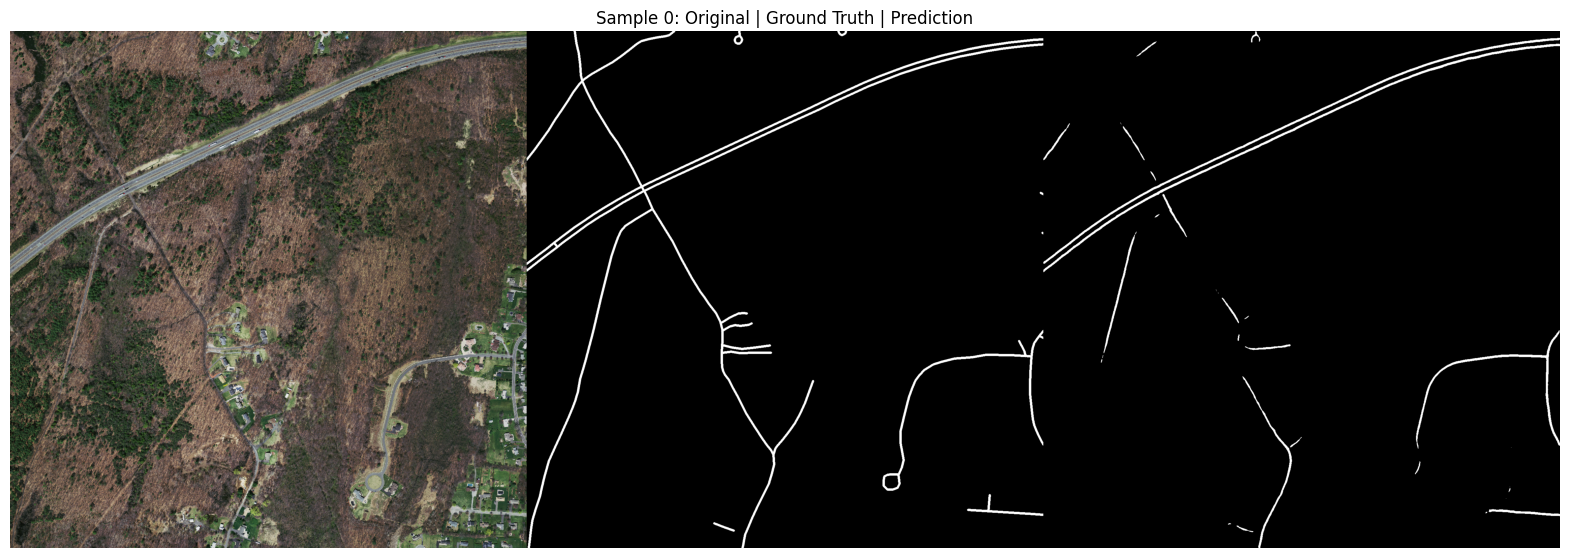

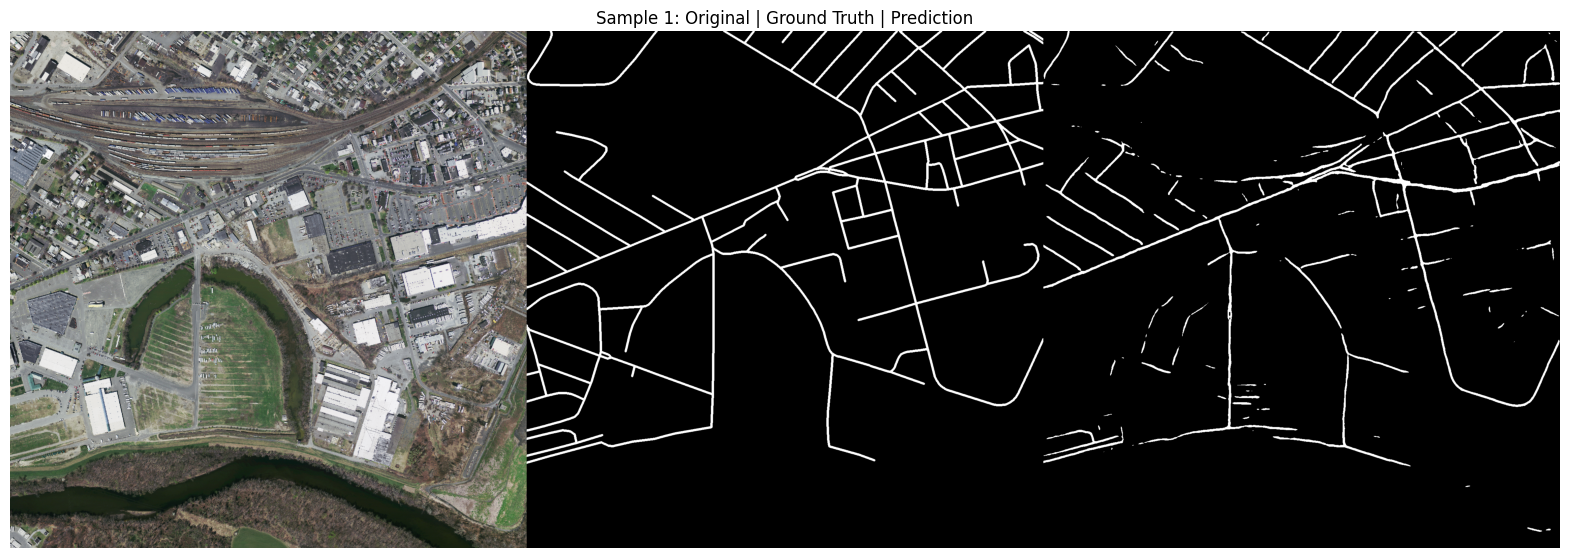

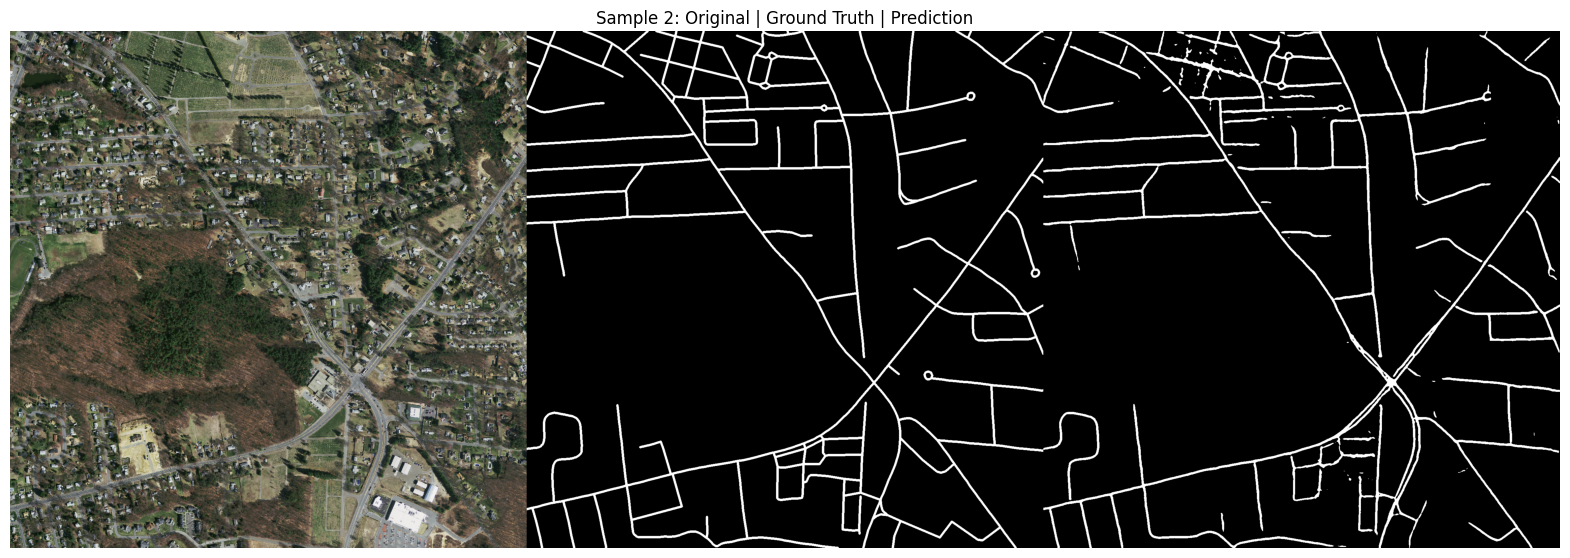

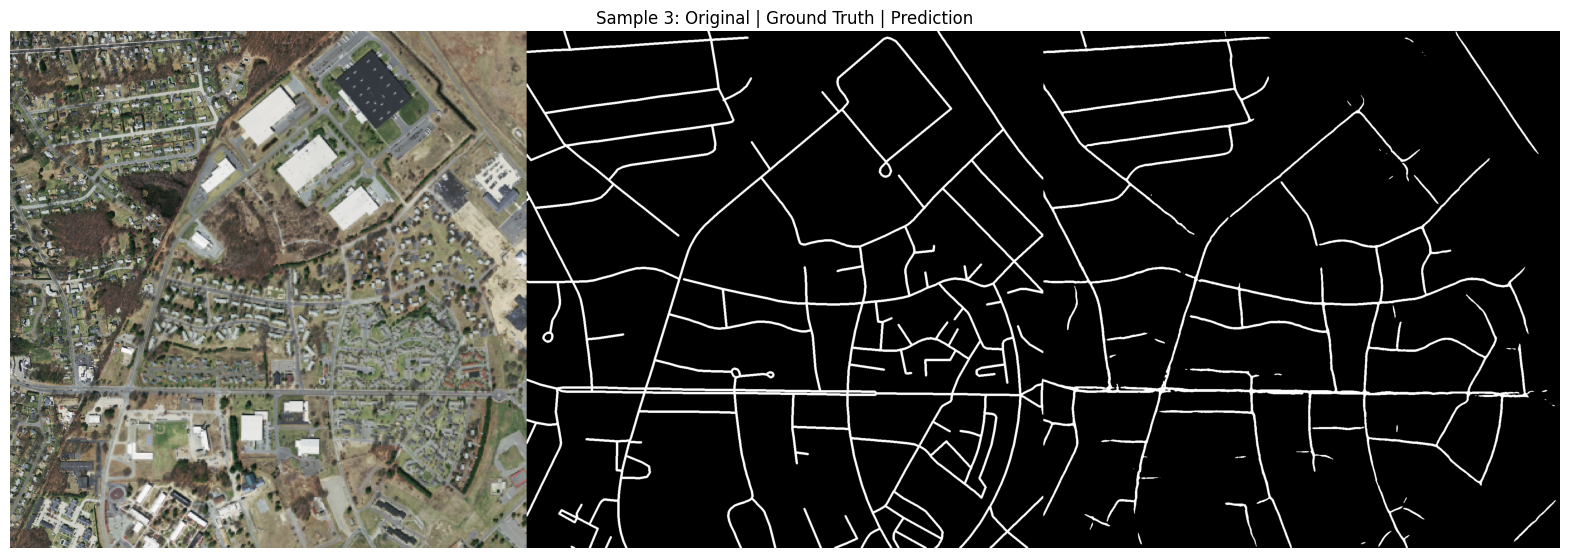

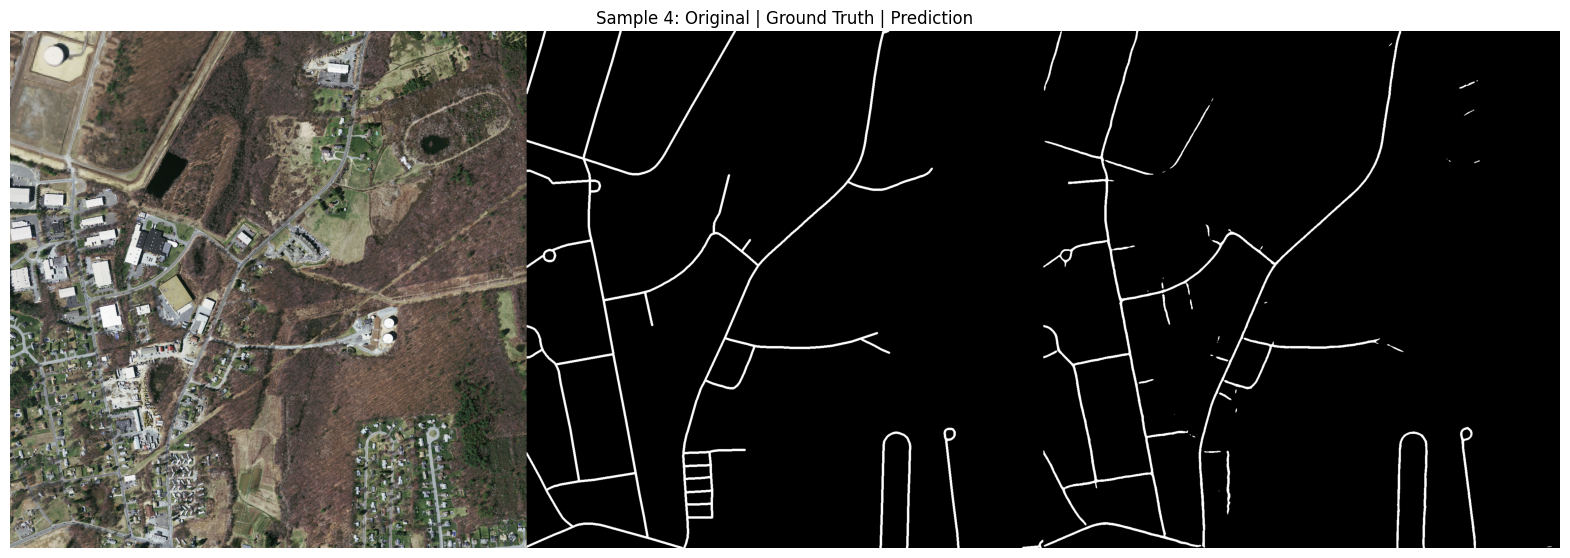

In [295]:
for idx in range(min(5, len(test_dataset))):
    pred_img = cv2.imread(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"))
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Sample {idx}: Original | Ground Truth | Prediction")
    plt.axis('off')
    plt.show()

In [296]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)

valid: 100%|██████████████████████████████| 49/49 [00:11<00:00,  4.35it/s, soft_bce_with_logits - 0.5367, iou_score - 0.9134, fscore - 0.9546, precision - 0.9372, recall - 0.9727]


In [297]:
print("Evaluation on Test Data: ")

for log in valid_logs:
    print(f"Mean {log}: {valid_logs[log]:.4f}")

Evaluation on Test Data: 
Mean soft_bce_with_logits: 0.5367
Mean iou_score: 0.9134
Mean fscore: 0.9546
Mean precision: 0.9372
Mean recall: 0.9727


<Axes: >

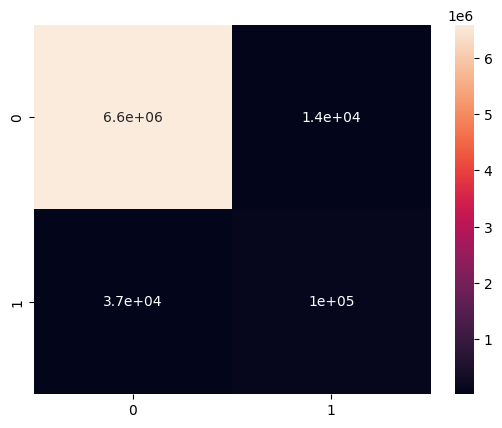

In [298]:
cm = confusion_matrix(gt_mask.flatten(), pred_mask.flatten())
sns.heatmap(cm, annot=True)

In [299]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)

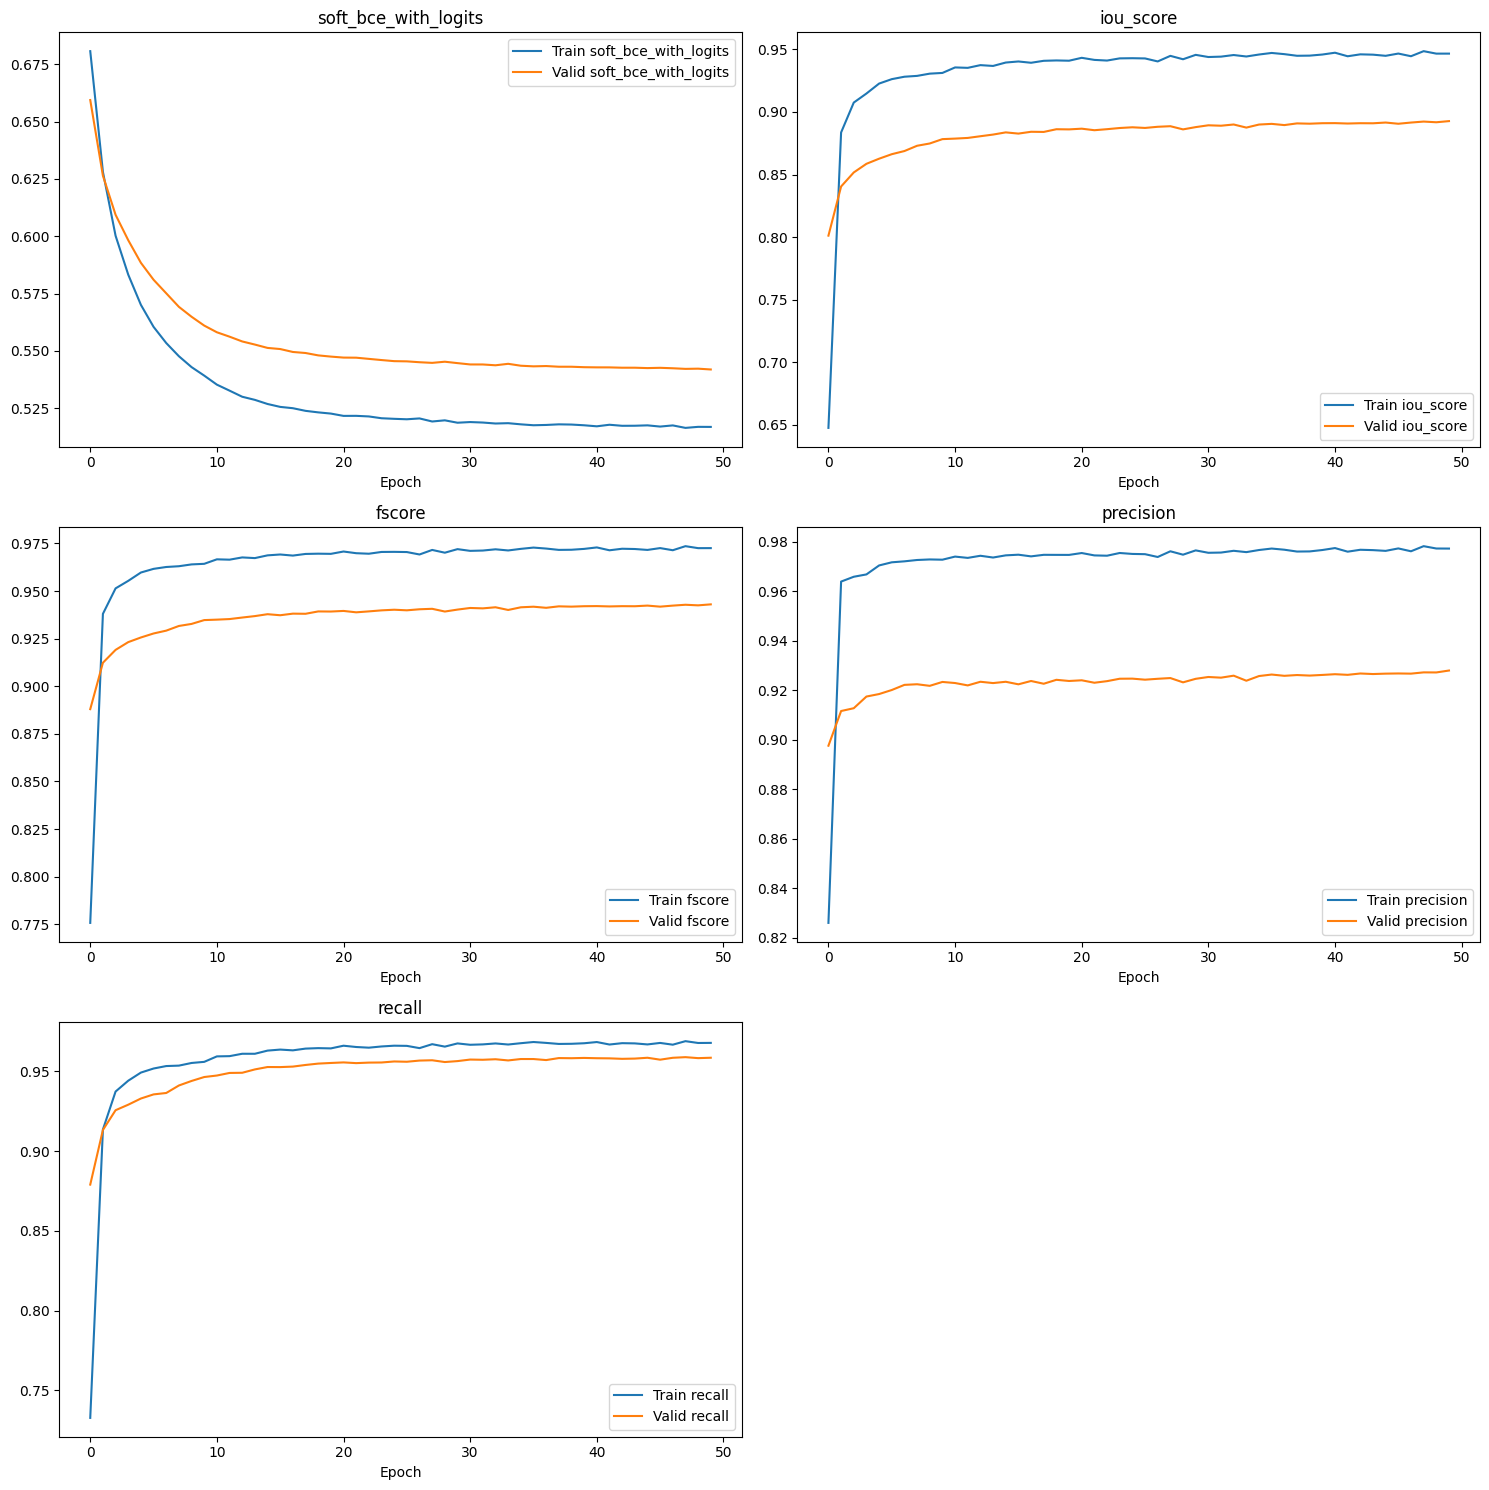

In [300]:
metrics_to_plot = [m for m in train_logs_df.columns if m != 'lr']
num_metrics = len(metrics_to_plot)

rows = int(np.ceil(num_metrics / 2))
cols = min(2, num_metrics)

plt.figure(figsize=(15, 5 * rows))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(rows, cols, i)
    plt.plot(train_logs_df[metric], label=f'Train {metric}')
    plt.plot(valid_logs_df[metric], label=f'Valid {metric}')
    plt.title(metric)
    plt.xlabel('Epoch')
    plt.legend()

plt.tight_layout()
plt.show()